# Stochastic Analysis

## load tables

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
agents_number_df = pd.read_csv('./agents_results.csv')
agents_number_df = agents_number_df.drop_duplicates(subset='damage')
agents_number_df = agents_number_df.loc[(agents_number_df['num_agents'] <= 500) & (agents_number_df['d'] == 5) & (agents_number_df['sigma'] == 1) & (agents_number_df['f'] == 1.5)]
agents_number_df = agents_number_df.groupby(['planner', 'num_agents'], as_index=False).mean()
agents_number_df.head()

In [23]:
f_df = pd.read_csv('./f_results.csv')
f_df = f_df.drop_duplicates(subset='damage')
f_df = f_df.loc[(f_df['num_agents'] == 300) & (f_df['f'] < 2.1)]
f_df = f_df.groupby(['planner', 'f'], as_index=False).mean()
f_df.head()

,planner,f,num_agents,num_robots,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticIterativePlanner,1.1,300.0,5.0,5.0,1.0,284.145790,0.944603,73015.404814,14.4760
1,StochasticIterativePlanner,1.2,300.0,5.0,5.0,1.0,274.548733,1.176596,70373.099547,29.3392
2,StochasticIterativePlanner,1.3,300.0,5.0,5.0,1.0,260.944014,1.578389,67969.607206,41.9170
3,StochasticIterativePlanner,1.4,300.0,5.0,5.0,1.0,258.105997,2.081960,65856.942674,53.5702
4,StochasticIterativePlanner,1.5,300.0,5.0,5.0,1.0,245.728732,2.243365,63730.420573,65.3150


In [24]:
robots_df = pd.read_csv('./robots_results.csv')
robots_df = robots_df.drop_duplicates(subset=['planner', 'damage'])
robots_df = robots_df.loc[(robots_df['f'] == 1.5)]
robots_df = robots_df.groupby(['planner', 'num_robots'], as_index=False).mean()
robots_df.head()

,planner,num_robots,num_agents,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticIterativePlanner,2,300.0,1.5,5.0,1.0,275.186345,1.522294,69089.898709,32.955
1,StochasticIterativePlanner,3,300.0,1.5,5.0,1.0,267.540872,1.779477,66925.894794,45.299
2,StochasticIterativePlanner,4,300.0,1.5,5.0,1.0,261.242169,2.176842,65393.962320,55.648
3,StochasticIterativePlanner,5,300.0,1.5,5.0,1.0,240.216426,2.362805,64004.893196,63.306
4,StochasticIterativePlanner,6,300.0,1.5,5.0,1.0,240.647679,2.687860,62082.478940,72.664


## visualizations

In [25]:
planners_colors = {'StochasticIterativePlanner': 'red',
                   'StochasticStaticLackPlanner': 'blue',
                   'StochasticAdditiveLackPlanner': 'orange',
                   'StochasticMonotone15LackPlanner': 'green',
                   'StochasticMonotone20LackPlanner': 'purple',
                   'StochasticMonotone30LackPlanner': 'olive',
                   'StochasticMonotone45LackPlanner': 'cyan'}

In [26]:
from typing import List

def visualize(X: List[str], Y: List[str], data, file_to_save: str, title: str):
    plt.figure(figsize=(14,10))
    plt.suptitle(title, fontsize=18)

    for i in range(len(Y)):
        x, y = X[i], Y[i]

        plt.subplot(2, 2, i+1)
        plt.xlabel(x)
        plt.ylabel(y)
        for j in range(len(data)):
            r = data[j]
            plt.plot(list(r[x]), list(r[y]), c=list(planners_colors.values())[j])

        if i==1:
            plt.legend(planners_colors.keys(), fontsize='14')

    plt.savefig(file_to_save)
    plt.show()

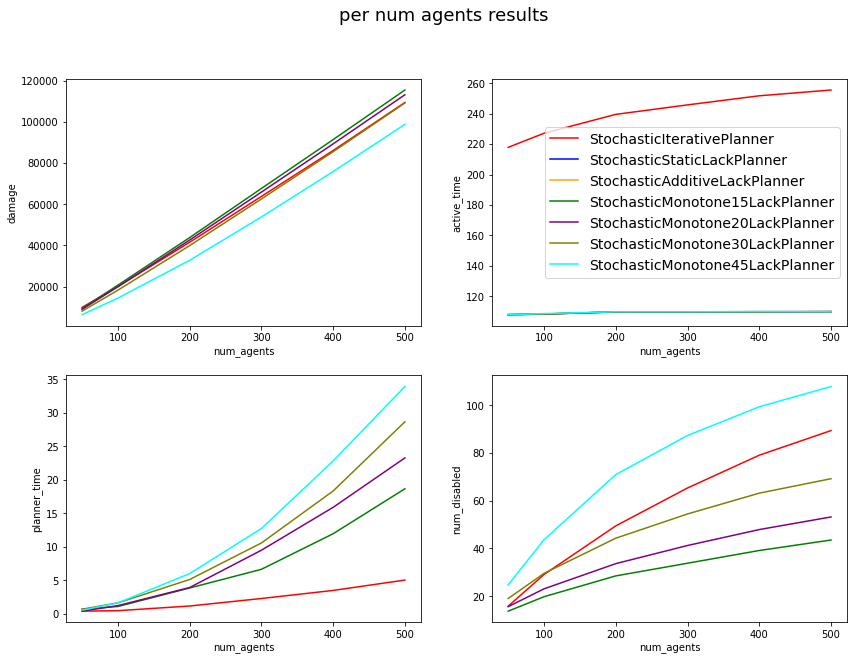

In [27]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_agents' for _ in Y]

agents_results = [agents_number_df.loc[agents_number_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num agents results'
file_to_save = './plots/stochastic_num_agents.png'

visualize(X, Y, agents_results, file_to_save, title)

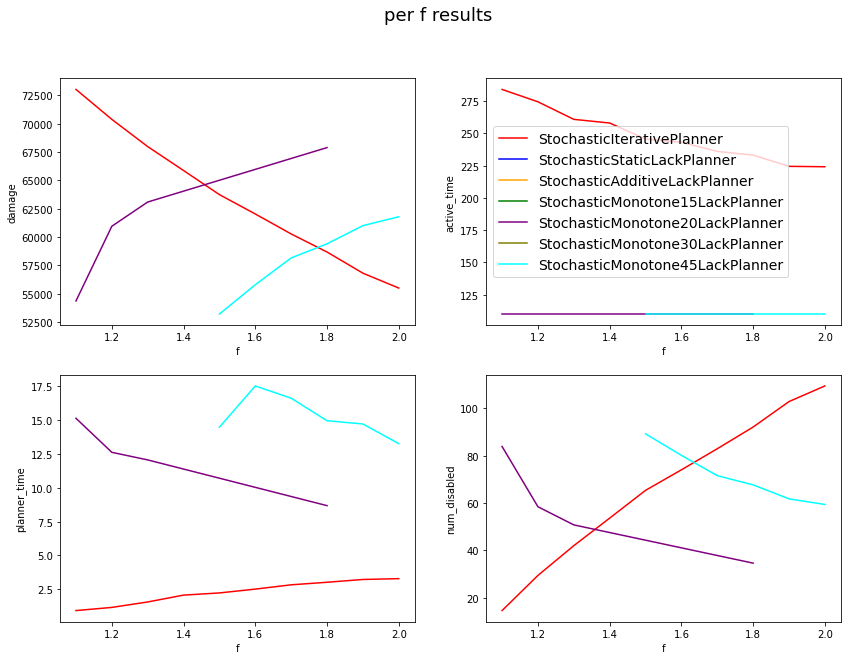

In [28]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['f' for _ in Y]

f_results = [f_df.loc[f_df['planner'] == name] for name in planners_colors.keys()]
title = 'per f results'
file_to_save = './plots/stochastic_f.png'

visualize(X, Y, f_results, file_to_save, title)

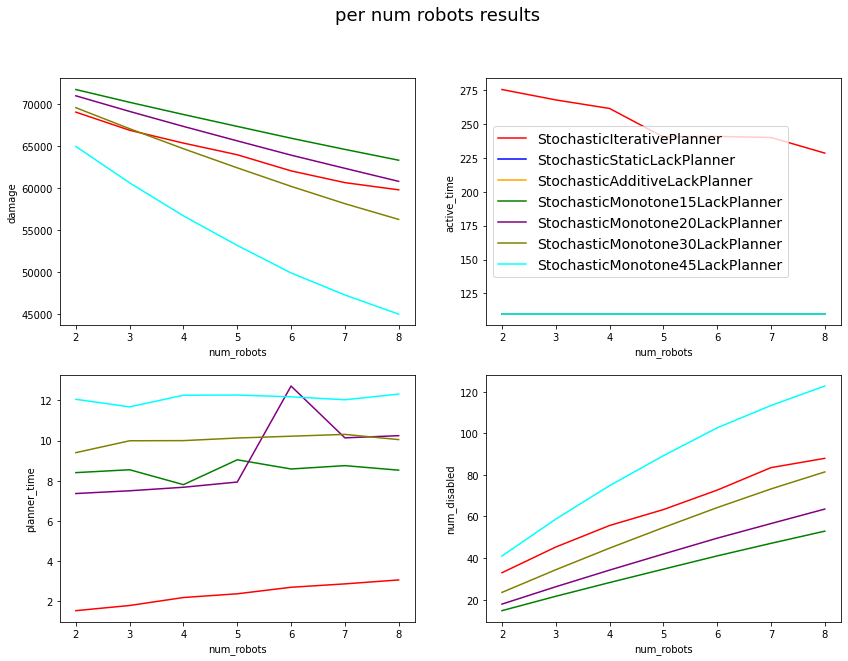

In [29]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_robots' for _ in Y]

robots_results = [robots_df.loc[robots_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num robots results'
file_to_save = './plots/stochastic_num_robots.png'

visualize(X, Y, robots_results, file_to_save, title)

## run experiments

### config file

In [10]:
import json
with open('config.json') as json_file:
    config = json.load(json_file)
config

{'x_size': 100,
 'y_size_init': 100,
 'y_size': 300,
 'x_buffer': 10,
 'y_buffer': 10,
 'num_robots': 5,
 'num_agents': 100,
 'agent_speed': 1,
 'robot_speed': 1.5,
 'disablement_range': 5,
 'sigma': 1}

In [11]:
import math
import time
from random import seed

from planners.stochastic.baseline.stochastic_iterative_planner import StochasticIterativePlanner
from planners.stochastic.partial_blockage.stochastic_additive_lack_planner import StochasticAdditiveLackPlanner
from planners.stochastic.partial_blockage.stochastic_monotone_lack_planner import StochasticMonotoneLackPlanner
from world.agents.stochastic_agent import StochasticAgent
from world.robots.timing_robot import TimingRobot
from world.stochastic_environment import StochasticEnvironment
from planners.planner import Planner
from planners.stochastic.partial_blockage.stochastic_static_lack_planner import StochasticStaticLackPlanner
from utils.functions import *

In [12]:
def run(planner: Planner, file_name: str):
    agents = [StochasticAgent(loc=sample_point(config['x_buffer'], config['x_buffer'] + config['x_size'],
                                               config['y_buffer'], config['y_buffer'] + config['y_size_init'], True),
                              v=config['agent_speed'], sigma=config['sigma']) for _ in range(config['num_agents'])]

    robots = [BasicRobot(sample_point(0, config['x_size'] + 2 * config['x_buffer'], 0, config['y_buffer'], True),
                         config['robot_speed'], config['disablement_range']) for _ in range(config['num_robots'])]

    env = StochasticEnvironment(agents=agents, robots=robots, top_border=config['y_size'] + config['y_buffer'],
                                right_border=config['x_size'] + config['x_buffer'], left_border=config['x_buffer'])

    before = time.time()
    _, active_time, expected_damage, expected_num_disabled = planner.plan(env)
    planning_time = time.time() - before

    write_report(planner=str(planner),
                 num_agents=config['num_agents'],
                 num_robots=config['num_robots'],
                 f=config['robot_speed'] / config['agent_speed'],
                 d=config['disablement_range'],
                 active_or_copmletion_time=active_time,
                 planner_time=planning_time,
                 damage=expected_damage,
                 num_disabled=expected_num_disabled,
                 file_name=file_name,
                 is_active_time=True,
                 sigma=config['sigma'])

In [13]:
planners = [StochasticMonotoneLackPlanner(), StochasticStaticLackPlanner(), StochasticAdditiveLackPlanner()]

for planner in planners:
    for alpha in [math.pi / 4]:
        planner.alpha = alpha
        for v in tqdm([100, 200, 300, 400, 500]):
            print(f'*** *** v={v} *** ***')
            for s in range(1):
                seed(s)

                config['num_agents'] = v
                print(f'running {str(planner)} with seed {s}..')
                run(planner, 'agents_results.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

*** *** v=100 *** ***
running StochasticMonotone45LackPlanner with seed 0..


 20%|██        | 1/5 [00:01<00:07,  1.95s/it]

*** *** v=200 *** ***
running StochasticMonotone45LackPlanner with seed 0..


 40%|████      | 2/5 [00:08<00:14,  4.86s/it]

*** *** v=300 *** ***
running StochasticMonotone45LackPlanner with seed 0..


 60%|██████    | 3/5 [00:23<00:18,  9.29s/it]

*** *** v=400 *** ***
running StochasticMonotone45LackPlanner with seed 0..


 80%|████████  | 4/5 [00:49<00:15, 15.75s/it]

*** *** v=500 *** ***
running StochasticMonotone45LackPlanner with seed 0..


  0%|          | 0/5 [00:00<?, ?it/s]

*** *** v=100 *** ***
running StochasticStaticLackPlanner with seed 0..


  0%|          | 0/5 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner(), StochasticStaticLackPlanner(),
#             StochasticAdditiveLackPlanner()]
planners = [StochasticMonotoneLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    for alpha in [math.pi / 9, math.pi / 12, math.pi / 3, math.pi / 4, math.pi / 6]:
        planner.alpha = alpha
        for v in tqdm([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]):
            print(f'*** *** v={v} *** ***')
            for s in range(5):
                seed(s)

                config['robot_speed'] = v
                print(f'running {str(planner)} with seed {s}..')
                try:
                    run(planner, 'f_results.csv')
                except:
                    pass

  0%|          | 0/10 [00:00<?, ?it/s]

*** *** v=1.1 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 10%|█         | 1/10 [01:15<11:19, 75.53s/it]

*** *** v=1.2 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 20%|██        | 2/10 [02:28<09:49, 73.74s/it]

*** *** v=1.3 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 30%|███       | 3/10 [03:24<07:42, 66.07s/it]

*** *** v=1.4 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 40%|████      | 4/10 [04:18<06:06, 61.11s/it]

*** *** v=1.5 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 50%|█████     | 5/10 [05:08<04:45, 57.02s/it]

*** *** v=1.6 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..


 60%|██████    | 6/10 [05:26<02:55, 43.93s/it]

running StochasticMonotone20LackPlanner with seed 4..
*** *** v=1.7 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 70%|███████   | 7/10 [05:33<01:35, 31.80s/it]

*** *** v=1.8 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 80%|████████  | 8/10 [05:54<00:56, 28.23s/it]

*** *** v=1.9 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


 90%|█████████ | 9/10 [06:20<00:27, 27.53s/it]

*** *** v=2 *** ***
running StochasticMonotone20LackPlanner with seed 0..
running StochasticMonotone20LackPlanner with seed 1..
running StochasticMonotone20LackPlanner with seed 2..
running StochasticMonotone20LackPlanner with seed 3..
running StochasticMonotone20LackPlanner with seed 4..


  0%|          | 0/10 [00:00<?, ?it/s]

*** *** v=1.1 *** ***
running StochasticMonotone15LackPlanner with seed 0..
running StochasticMonotone15LackPlanner with seed 1..
running StochasticMonotone15LackPlanner with seed 2..
running StochasticMonotone15LackPlanner with seed 3..
running StochasticMonotone15LackPlanner with seed 4..


 10%|█         | 1/10 [00:17<02:35, 17.30s/it]

*** *** v=1.2 *** ***
running StochasticMonotone15LackPlanner with seed 0..
running StochasticMonotone15LackPlanner with seed 1..
running StochasticMonotone15LackPlanner with seed 2..
running StochasticMonotone15LackPlanner with seed 3..
running StochasticMonotone15LackPlanner with seed 4..


 20%|██        | 2/10 [00:18<01:01,  7.73s/it]

*** *** v=1.3 *** ***
running StochasticMonotone15LackPlanner with seed 0..
running StochasticMonotone15LackPlanner with seed 1..


In [13]:
planners = [StochasticMonotoneLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    for alpha in [math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
        planner.alpha = alpha
        for v in tqdm([2,3,4,5,6,7,8]):
            print(f'*** *** v={v} *** ***')
            for s in range(10,30):
                seed(s)

                config['num_robots'] = v
                print(f'running {str(planner)} with seed {s}..')
                run(planner, 'robots_results.csv')

  0%|          | 0/7 [00:00<?, ?it/s]

*** *** v=2 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

 14%|█▍        | 1/7 [03:59<23:55, 239.17s/it]

*** *** v=3 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

 29%|██▊       | 2/7 [07:50<19:32, 234.48s/it]

*** *** v=4 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

 43%|████▎     | 3/7 [11:53<15:53, 238.28s/it]

*** *** v=5 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

 57%|█████▋    | 4/7 [15:56<12:00, 240.25s/it]

*** *** v=6 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

 71%|███████▏  | 5/7 [19:57<08:00, 240.37s/it]

*** *** v=7 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

 86%|████████▌ | 6/7 [23:54<03:59, 239.24s/it]

*** *** v=8 *** ***
running StochasticMonotone45LackPlanner with seed 10..
running StochasticMonotone45LackPlanner with seed 11..
running StochasticMonotone45LackPlanner with seed 12..
running StochasticMonotone45LackPlanner with seed 13..
running StochasticMonotone45LackPlanner with seed 14..
running StochasticMonotone45LackPlanner with seed 15..
running StochasticMonotone45LackPlanner with seed 16..
running StochasticMonotone45LackPlanner with seed 17..
running StochasticMonotone45LackPlanner with seed 18..
running StochasticMonotone45LackPlanner with seed 19..
running StochasticMonotone45LackPlanner with seed 20..
running StochasticMonotone45LackPlanner with seed 21..
running StochasticMonotone45LackPlanner with seed 22..
running StochasticMonotone45LackPlanner with seed 23..
running StochasticMonotone45LackPlanner with seed 24..
running StochasticMonotone45LackPlanner with seed 25..
running StochasticMonotone45LackPlanner with seed 26..
running StochasticMonotone45LackPlanner with 

  0%|          | 0/7 [00:00<?, ?it/s]

*** *** v=2 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

 14%|█▍        | 1/7 [03:06<18:39, 186.60s/it]

*** *** v=3 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

 29%|██▊       | 2/7 [06:25<16:08, 193.75s/it]

*** *** v=4 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

 43%|████▎     | 3/7 [09:44<13:04, 196.04s/it]

*** *** v=5 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

 57%|█████▋    | 4/7 [13:04<09:53, 197.94s/it]

*** *** v=6 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

 71%|███████▏  | 5/7 [16:27<06:39, 199.68s/it]

*** *** v=7 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

 86%|████████▌ | 6/7 [19:52<03:21, 201.40s/it]

*** *** v=8 *** ***
running StochasticMonotone30LackPlanner with seed 10..
running StochasticMonotone30LackPlanner with seed 11..
running StochasticMonotone30LackPlanner with seed 12..
running StochasticMonotone30LackPlanner with seed 13..
running StochasticMonotone30LackPlanner with seed 14..
running StochasticMonotone30LackPlanner with seed 15..
running StochasticMonotone30LackPlanner with seed 16..
running StochasticMonotone30LackPlanner with seed 17..
running StochasticMonotone30LackPlanner with seed 18..
running StochasticMonotone30LackPlanner with seed 19..
running StochasticMonotone30LackPlanner with seed 20..
running StochasticMonotone30LackPlanner with seed 21..
running StochasticMonotone30LackPlanner with seed 22..
running StochasticMonotone30LackPlanner with seed 23..
running StochasticMonotone30LackPlanner with seed 24..
running StochasticMonotone30LackPlanner with seed 25..
running StochasticMonotone30LackPlanner with seed 26..
running StochasticMonotone30LackPlanner with 

  0%|          | 0/7 [00:00<?, ?it/s]

*** *** v=2 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

 14%|█▍        | 1/7 [02:25<14:35, 145.93s/it]

*** *** v=3 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

 29%|██▊       | 2/7 [04:54<12:18, 147.73s/it]

*** *** v=4 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

 43%|████▎     | 3/7 [07:27<09:58, 149.73s/it]

*** *** v=5 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

 57%|█████▋    | 4/7 [10:04<07:38, 152.92s/it]

*** *** v=6 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

 71%|███████▏  | 5/7 [14:22<06:21, 190.80s/it]

*** *** v=7 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

 86%|████████▌ | 6/7 [17:46<03:15, 195.27s/it]

*** *** v=8 *** ***
running StochasticMonotone20LackPlanner with seed 10..
running StochasticMonotone20LackPlanner with seed 11..
running StochasticMonotone20LackPlanner with seed 12..
running StochasticMonotone20LackPlanner with seed 13..
running StochasticMonotone20LackPlanner with seed 14..
running StochasticMonotone20LackPlanner with seed 15..
running StochasticMonotone20LackPlanner with seed 16..
running StochasticMonotone20LackPlanner with seed 17..
running StochasticMonotone20LackPlanner with seed 18..
running StochasticMonotone20LackPlanner with seed 19..
running StochasticMonotone20LackPlanner with seed 20..
running StochasticMonotone20LackPlanner with seed 21..
running StochasticMonotone20LackPlanner with seed 22..
running StochasticMonotone20LackPlanner with seed 23..
running StochasticMonotone20LackPlanner with seed 24..
running StochasticMonotone20LackPlanner with seed 25..
running StochasticMonotone20LackPlanner with seed 26..
running StochasticMonotone20LackPlanner with 

  0%|          | 0/7 [00:00<?, ?it/s]

*** *** v=2 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

 14%|█▍        | 1/7 [02:48<16:49, 168.32s/it]

*** *** v=3 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

 29%|██▊       | 2/7 [05:40<14:13, 170.64s/it]

*** *** v=4 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

 43%|████▎     | 3/7 [08:17<10:56, 164.23s/it]

*** *** v=5 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

 57%|█████▋    | 4/7 [11:19<08:34, 171.53s/it]

*** *** v=6 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

 71%|███████▏  | 5/7 [14:12<05:43, 171.90s/it]

*** *** v=7 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

 86%|████████▌ | 6/7 [17:08<02:53, 173.33s/it]

*** *** v=8 *** ***
running StochasticMonotone15LackPlanner with seed 10..
running StochasticMonotone15LackPlanner with seed 11..
running StochasticMonotone15LackPlanner with seed 12..
running StochasticMonotone15LackPlanner with seed 13..
running StochasticMonotone15LackPlanner with seed 14..
running StochasticMonotone15LackPlanner with seed 15..
running StochasticMonotone15LackPlanner with seed 16..
running StochasticMonotone15LackPlanner with seed 17..
running StochasticMonotone15LackPlanner with seed 18..
running StochasticMonotone15LackPlanner with seed 19..
running StochasticMonotone15LackPlanner with seed 20..
running StochasticMonotone15LackPlanner with seed 21..
running StochasticMonotone15LackPlanner with seed 22..
running StochasticMonotone15LackPlanner with seed 23..
running StochasticMonotone15LackPlanner with seed 24..
running StochasticMonotone15LackPlanner with seed 25..
running StochasticMonotone15LackPlanner with seed 26..
running StochasticMonotone15LackPlanner with 

100%|██████████| 7/7 [19:59<00:00, 171.39s/it]
